# Plot downsampled Ancients
Take the high-coverage Ancients, and plot results from their downampled Versions
1. Ancient SA: Are prepared in ./PrepareData/prepare_SA_readcount.ipynb and then run via ./ParallelRuns/parallel_AS_hdf5_callroh.ipynb

Here: For each Individual: Load RC and PH Inference, as well as Reich Eigenstrat PH inference. Then plot in one plot (if not loaded and not given to plotting function, not plotted)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os  # For Saving to Folder
import pandas as pd
from matplotlib import gridspec

##############################
import socket
import os as os
import sys as sys
import multiprocessing as mp

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the default
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

sys.path.append("./package/hapsburg/PackagesSupport/")
from pp_individual_roh_csvs import create_combined_ROH_df

midway2-0403.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


## Prepare Data

### Ancient South Americans: Take example IPK12

### Load downsampled Inference

In [2]:
def prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Loschbour/", iid = "Loschbour",
                   suffix = "_roh_full.csv", down_sampling_covs=np.geomspace(0.01, 1.0, 10), cms = [4, 8, 12],
                   gap = 0.5, min_len1=2.0, min_len2=4.0, tot_cov=19.5486, prefix=""):
    """Prepare Dataframe of results -> Combine Individual results into one dataframe"""
    samples = np.array([prefix + f"{c:.4f}" for c in down_sampling_covs])   # Numpy Array for better slicing
    paths = [os.path.join(base_path, s[:10] + suffix) for s in samples]
    df_t = create_combined_ROH_df(paths, samples, pops=samples, min_cm=cms, snp_cm=50, 
                                  gap=gap, min_len1=min_len1, min_len2=min_len2,
                                  output=False)
    df_t["mean_cov"] = down_sampling_covs * tot_cov   #* 10.439 for IPK12
    return df_t

############################################
### Create figure

def plot_downsample_ind(df_rc, df_ph=[], df_ph_reich=[], cms=[4,8,12], cms1=[], fs=10, fs_leg=10, figsize=(7,5),
                        title="IKP12, Patagonia, 1000y BP", xlim=[0, 2], ylim=[0, 550],
                        savepath="", y_label="", hlines=7):
    """Plot downsampled Individual.
    df_ph: If given, plot pseudohaploid data
    hlines: Whether to plot the ground truth lines"""
    if len(cms1)==0:  # Set to default value
        cms1=np.zeros(len(cms), dtype="int")
    assert(len(cms)==len(cms1))  # Sanity Check
    
    mss = ["bo-", "bo--", "bo-."]
    plt.figure(figsize=figsize)
    ax=plt.gca()
    
    ### Prepare the statistics to plot
    y_reich = np.zeros(len(cms)) # Place Holder for Plot
    
    for i, cm in enumerate(cms):
        cm1 = cms1[i]
        
        if cm1<=0:
            y_rc = df_rc[f"sum_roh>{cm}"]
            label_rc = f">{cm}cm (Readcounts)"
            
            if len(df_ph)>0:
                label_ph = f">{cm}cm (Pseudohaploid)"
                y_ph = df_ph[f"sum_roh>{cm}"]
                
            if len(df_ph_reich)>0:
                y_reich[i] = df_ph_reich[f"sum_roh>{cm}"].values[0]
        
        elif cm1>0:
            y_rc = df_rc[f"sum_roh>{cm}"] - df_rc[f"sum_roh>{cm1}"]
            label_rc=f"{cm}-{cm1}cm (Readcounts)"
            
            if len(df_ph)>0:
                label_ph = f"{cm}-{cm1}cm (Pseudohaploid)"
                y_ph =  df_ph[f"sum_roh>{cm}"] - df_ph[f"sum_roh>{cm1}"]
                
            if len(df_ph_reich)>0:
                y_reich[i] = (df_ph_reich[f"sum_roh>{cm}"].values[0] - 
                           df_ph_reich[f"sum_roh>{cm1}"].values[0])
                                            
        ### Plot the RC Dots
        ax.plot(df_rc["mean_cov"], y_rc, mss[i], label=label_rc, 
                lw=1.5, ms=6, zorder=1, color="b")

        ###### Plot PH Dots
        if len(df_ph)>0:
            ax.plot(df_ph["mean_cov"], y_ph, mss[i], 
                    label=label_ph, lw=1.5, ms=6, zorder=0, color="r")  
            
        ###### Plot Axhline
        if hlines>0:
            ax.axhline(y_rc.values[hlines], lw=1, zorder=0, c="gray")
        
    ###### Plot Reich Plot (only one legend label)
    if len(df_ph_reich)>0:
        ax.scatter(np.ones(len(y_reich)), y_reich, c="r", s=80, ec="k",  
                   label = "PseudoHaploid (Eigenstrat)", zorder=1)
        
    ax.legend(loc="upper right", fontsize=fs_leg)
    ax.set_ylim(ylim)
    
    if len(y_label)==0:
        y_label="Sum ROH >x cM [cM]"
    ax.set_ylabel(y_label, fontsize=fs)
    ax.set_xlabel("Mean Depth", fontsize=fs)
    ax.set_title(title, fontsize=fs)
    #plt.xscale("log")
    ax.set_xlim(xlim)
    ax.axvline(0.5, c="r")
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved Figure to: {savepath}")
    plt.show()
    
def prepare_sums_in_bins(df, cms=[4,8,12]):
    """Prepare Sums in Bins from the greater columnds.
    Return dataframe with updated columns"""
    for i in range(len(cms)-1):
        cm1,cm2=cms[i], cms[i+1]
        df[f"sum_roh>{cm1}"] = df[f"sum_roh>{cm1}"] - df[f"sum_roh>{cm2}"]
    return df

### Do IPKG12, South America

In [3]:
### Load Readcount Data
df_rc = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_IPK12/", iid = "IPK12",
                       suffix = "_roh_full.csv", down_sampling_covs = np.geomspace(0.04, 1.0, 10), cms = [4, 8, 12],
                       gap = 0.5, min_len1=2, min_len2=2, tot_cov=10.438989, prefix="IPK12")

In [4]:
### Reich Eigenstrat PH
paths = ["./Empirical/Eigenstrat/Reichall/IPK12.SG_roh_full.csv",]
cms = [4, 8, 12]
iids=np.array(["IPK12,"])
df_ph_reich = create_combined_ROH_df(paths, iids, iids, min_cm=cms, snp_cm=50, gap=0.5, output=False, 
                                     min_len1=2, min_len2=2)

In [5]:
### Downsampled PH
df_ph = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_IPK12/", iid = "IPK12",
                       suffix = "_roh_full.csv", down_sampling_covs=np.linspace(0.3, 0.8, 6), cms = [4, 8, 12],
                       gap = 0.5, min_len1=2, min_len2=2,
                       tot_cov=1.0, prefix="IPK12")  # Keep in mind the overall folder -> it's not PH bc old run diff

Saved Figure to: ./figures/manuscript/supplement/downsampling_sa/ipk12_patagonia_minlen4.pdf


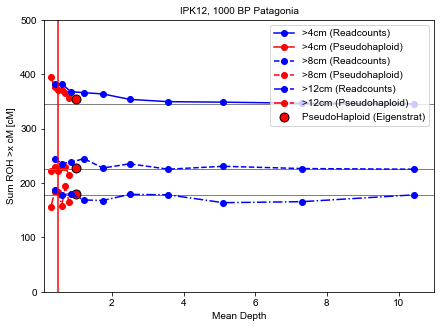

In [97]:
plot_downsample_ind(df_rc, df_ph=df_ph, df_ph_reich=df_ph_reich, 
                    title="IPK12, 1000 BP Patagonia", ylim=[0,500], xlim=[0.1, 11],
                    savepath="", hlines=9) # ./figures/manuscript/supplement/downsampling_sa/ipk12_patagonia_minlen4.pdf

Saved Figure to: ./figures/manuscript/supplement/downsampling_sa/ipk12_patagonia_minlen4_4-8.pdf


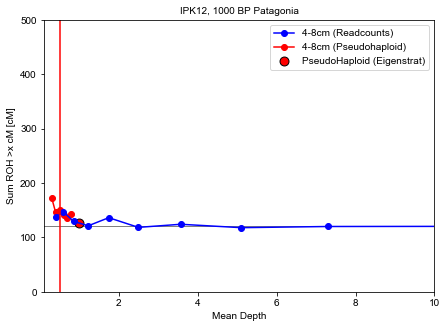

In [103]:
plot_downsample_ind(df_rc, df_ph=df_ph, df_ph_reich=df_ph_reich, 
                    title="IPK12, 1000 BP Patagonia", ylim=[0,500], xlim=[0.1, 10],
                    savepath="./figures/manuscript/supplement/downsampling_sa/ipk12_patagonia_minlen4_4-8.pdf", 
                    cms=[4], cms1=[8], hlines=9) # ./figures/manuscript/supplement/downsampling_sa/ipk12_patagonia_minlen4.pdf

### Plot sum in the bins

In [30]:
df_rc_bins = prepare_sums_in_bins(df_rc, cms=[4,8,12])
df_ph_bins = prepare_sums_in_bins(df_ph, cms=[4,8,12])
df_ph_reich_bins = prepare_sums_in_bins(df_ph_reich, cms=[4,8,12])

Saved Figure to: ./figures/manuscript/supplement/downsampling_sa/ipk12_patagonia_minlen4_8.pdf


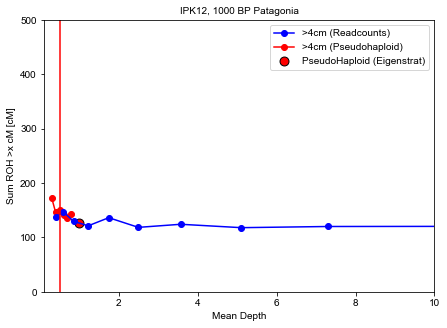

In [31]:
plot_downsample_ind(df_rc_bins, df_ph=df_ph_bins, df_ph_reich=df_ph_reich_bins, 
                    title="IPK12, 1000 BP Patagonia", ylim=[0,500], xlim=[0.1,10], cms=[4,],
                    savepath="./figures/manuscript/supplement/downsampling_sa/ipk12_patagonia_minlen4_8.pdf")

### Do Loschbour, WHG

In [102]:
### Downsampled Readcount
df_rc = prep_rc_res_df(base_path = './Empirical/1240k/SA_Readcounts/Downsample_Loschbour0/', iid = "Loschbour",
                       tot_cov=19.5486, gap=0.5, min_len1=2.0, min_len2=4.0)

### Loschbour0 is original folder (from first run). Loschbour for resampled version

In [103]:
### Reich Eigenstrat PH
paths = ["./Empirical/Eigenstrat/Reichall/Loschbour_snpAD.DG_roh_full.csv",]
cms = [4, 8, 12]
iids=np.array(["Loschbour_snpAD.DG,"])
df_ph_reich = create_combined_ROH_df(paths, iids, iids, min_cm=cms, snp_cm=50, 
                                     gap=1.0, min_len1=2.0, min_len2=4.0, output=False)

In [105]:
### Downsampled PH
df_ph = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Loschbour_phv2/", iid = "Loschbour",
                       suffix = "_roh_full.csv", down_sampling_covs=np.linspace(0.3, 0.9, 7), cms = [4, 8, 12],
                       gap = 1.0, min_len1=2.0, min_len2=4.0, tot_cov=1.0)

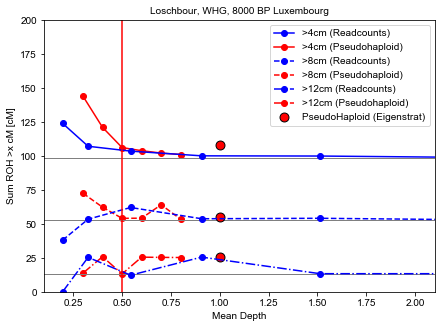

In [101]:
plot_downsample_ind(df_rc, df_ph=df_ph, df_ph_reich=df_ph_reich, 
                    title="Loschbour, WHG, 8000 BP Luxembourg", ylim=[0,200], xlim=[0.1,7.1],
                    savepath="", hlines=7) # ./figures/manuscript/supplement/downsampling_sa/loschbour_whg_len4.pdf

Saved Figure to: ./figures/manuscript/supplement/downsampling_sa/loschbour_whg_len4_4-8.pdf


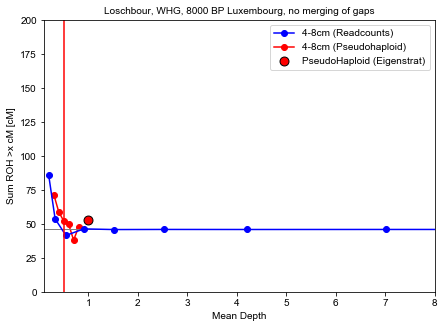

In [79]:
plot_downsample_ind(df_rc, df_ph=df_ph, df_ph_reich=df_ph_reich, 
                    title="Loschbour, WHG, 8000 BP Luxembourg, no merging of gaps", ylim=[0,200], xlim=[0.1,8],
                    cms=[4], cms1=[8],
                    savepath="./figures/manuscript/supplement/downsampling_sa/loschbour_whg_len4_4-8.pdf") # ./figures/manuscript/supplement/downsampling_sa/loschbour_whg_len4.pdf

## Legacy: Loschbour with 7 SNP cutoff on each side
This has not much effect, at least not much as hoped for.

In [61]:
### Downsampled Readcount
df_rc = prep_rc_res_df(tot_cov=19.5486)

### Reich Eigenstrat PH
paths = ["./Empirical/Eigenstrat/Reichall/Loschbour_snpAD.DG_roh_full.csv",]
cms = [4, 8, 12]
iids=np.array(["IPK12,"])
df_ph_reich = create_combined_ROH_df(paths, iids, iids, min_cm=cms, snp_cm=50, gap=0.5, output=False)

### Downsampled PH
df_ph = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Loschbour_ph/", iid = "Loschbour",
                       suffix = "_roh_fullE7.csv", down_sampling_covs=np.linspace(0.3, 0.8, 6), cms = [4, 8, 12],
                       gap = 0.0, tot_cov=1.0)

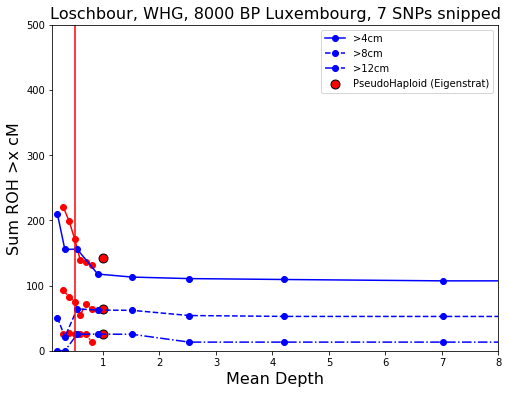

In [62]:
plot_downsample_ind(df_rc, df_ph=df_ph, df_ph_reich=df_ph_reich, 
                    title="Loschbour, WHG, 8000 BP Luxembourg, 7 SNPs snipped", ylim=[0,500], xlim=[0.1,8])

### Compare snipped and non-snipped

In [50]:
df_ph1 = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Loschbour_ph/", iid = "Loschbour",
                       suffix = "_roh_full.csv", down_sampling_covs=np.linspace(0.3, 0.8, 6), cms = [4, 8, 12],
                       gap = 0.5, tot_cov=1.0, min_len1=2.0, min_len2=4.0)

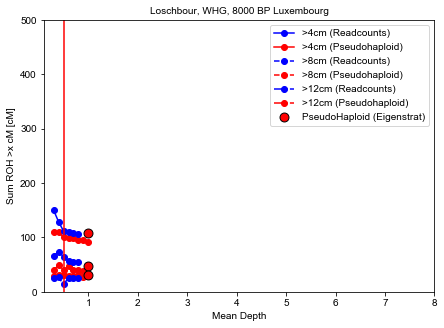

In [53]:
plot_downsample_ind(df_ph1, df_ph=df_ph, df_ph_reich=df_ph_reich, 
                    title="Loschbour, WHG, 8000 BP Luxembourg", ylim=[0,500], xlim=[0.1,8])

### Do Stuttgart EEF

In [121]:
### Load Readcount Data
df_rc = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Stuttgart/", iid = "Stuttgart",
                       suffix = "_roh_full.csv", down_sampling_covs=np.geomspace(0.01, 1.0, 10)[:], cms = [4, 8, 12],
                       gap = 0.5, min_len1=2.0, min_len2=4.0, tot_cov=18.2127)

In [122]:
### Reich Eigenstrat PH
paths = ["./Empirical/Eigenstrat/Reichall/Stuttgart_published.DG_roh_full.csv",]
cms = [4, 8, 12]
iids=np.array(["Stuttgart_published,"])
df_ph_reich = create_combined_ROH_df(paths, iids, iids, min_cm=cms, snp_cm=50, 
                                     gap=0.5, min_len1=2.0, min_len2=4.0, output=False)

In [123]:
### Downsampled PH
df_ph = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Stuttgart_ph//", iid = "Stuttgart",
                       suffix = "_roh_full.csv", down_sampling_covs=np.linspace(0.3, 1.0, 8), cms = [4, 8, 12],
                       gap = 0.5, min_len1=2.0, min_len2=4.0, tot_cov=1.0)

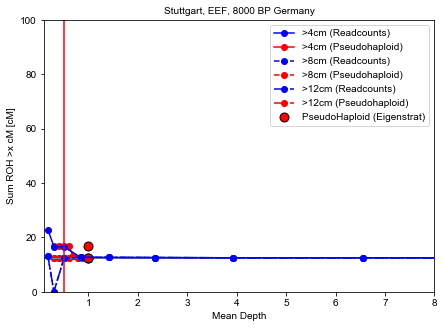

In [124]:
plot_downsample_ind(df_rc, df_ph=df_ph, df_ph_reich=df_ph_reich, title="Stuttgart, EEF, 8000 BP Germany", 
                    ylim=[0,100], xlim=[0.1,8])

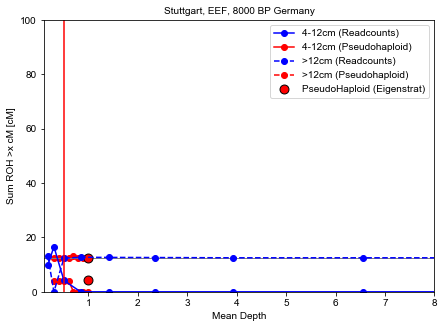

In [125]:
plot_downsample_ind(df_rc, df_ph=df_ph, df_ph_reich=df_ph_reich, title="Stuttgart, EEF, 8000 BP Germany", 
                    ylim=[0,100], xlim=[0.1,8],
                   cms=[4,12], cms1=[12,0])

## Ust Ishim (45k years old)

In [106]:
### Load Readcount Data
df_rc = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Ust_Ishim0/", iid = "Ust_Ishim",
                          suffix = "_roh_fullE7.csv", down_sampling_covs=np.geomspace(0.005, 1.0, 10)[:], cms = [4, 8, 12],
                            gap = 0.5, min_len1=2, min_len2=4.0, tot_cov=40.0)

In [107]:
### Reich Eigenstrat PH
paths = ["./Empirical/Eigenstrat/Reichall/UstIshim_snpAD.DG_roh_full.csv",]
cms = [4, 8, 12]
iids=np.array(["UstIshim_snpAD.DG"])
df_ph_reich = create_combined_ROH_df(paths, iids, iids, min_cm=cms, snp_cm=50, 
                                     gap=0.5, min_len1=2, min_len2=4, output=False)

In [109]:
### Downsampled PH
df_ph = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Ust_Ishim_phv2/", iid = "Ust_Ishim",
                       suffix = "_roh_full.csv", down_sampling_covs=np.linspace(0.3, 0.9, 7), cms = [4, 8, 12],
                       gap = 1.0, min_len1=2, min_len2=4.0, tot_cov=1.0)

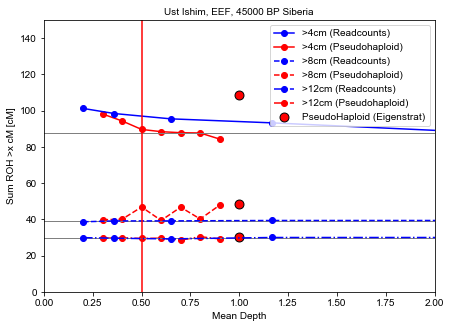

In [97]:
plot_downsample_ind(df_rc, df_ph=df_ph, df_ph_reich=df_ph_reich, title="Ust Ishim, EEF, 45000 BP Siberia", 
                    ylim=[0,150], xlim=[0,2], savepath="")

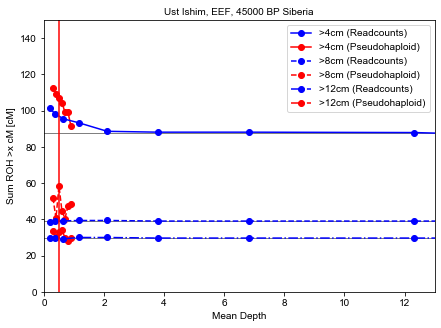

In [88]:
plot_downsample_ind(df_rc, df_ph=df_ph, df_ph_reich=[], title="Ust Ishim, EEF, 45000 BP Siberia", 
                    ylim=[0,150], xlim=[0,13], savepath="")  # ./figures/manuscript/supplement/downsampling_sa/ust_ishim_l4.pdf

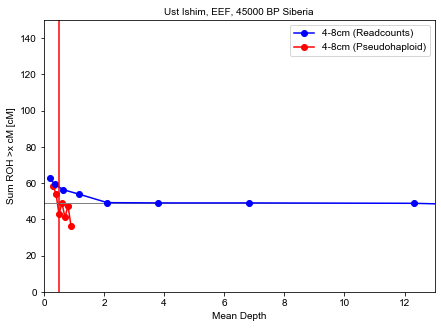

In [94]:
plot_downsample_ind(df_rc, df_ph=df_ph, df_ph_reich=[], title="Ust Ishim, EEF, 45000 BP Siberia", 
                    cms=[4], cms1=[8],
                    ylim=[0,150], xlim=[0,13], savepath="")  # ./figures/manuscript/supplement/downsampling_sa/ust_ishim_l4.pdf

# Area 51

# Compare SA Readcount with PH

In [3]:
from pp_individual_roh_csvs import create_combined_ROH_df, give_iid_paths, pp_individual_roh

In [4]:
iids = np.array(["A460", "Andaman", "5832", "Lovelock4", "Sumidouro4","Sumidouro5", 
        "Sumidouro6", "Sumidouro7"]) #, "19651", "AHUR_2064", "Lovelock1", "Lovelock2", "Lovelock3", "Aconcagua"]

In [37]:
paths = give_iid_paths(iids, base_folder="./Empirical/1240k/SA_Readcounts/", suffix='_roh_full.csv')
df1 = create_combined_ROH_df(paths, iids, pops=iids, min_cm=[4, 8, 12], snp_cm=50, gap=0.5, output=False)

In [38]:
df_es = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_es["iid"] = df_es["iid"].str.split(".", expand=True)[0]

In [46]:
df_merge = pd.merge(df1, df_es, on="iid")
df_merge = df_merge[df_merge["mean_cov"]>10]

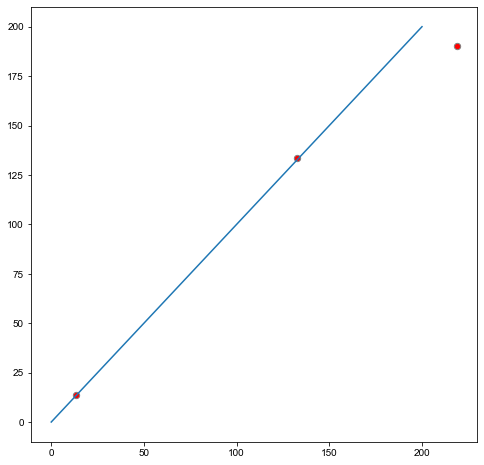

Correlation: 0.9938


In [49]:
cm1, cm2 = 4, 
x = df_merge[f"sum_roh>{cm1}_x"] #- df_merge[f"sum_roh>{cm2}_x"]
y = df_merge[f"sum_roh>{cm1}_y"] #- df_merge[f"sum_roh>{cm2}_y"]

plt.figure(figsize=(8,8))
plt.scatter(x, y, s=40, c="r", ec="gray")
plt.plot([0,200],[0,200])
plt.show()

print(f"Correlation: {np.corrcoef(x,y)[0,1]:.4f}")

In [42]:
np.mean(y-x)

40.38546733333332